# PV-IN KCNC2 Kv3.2 A new genetic cause of childhood epilepsy


## imports and config


In [1]:
%load_ext autoreload
%autoreload 2
import logging
import platform

from functools import lru_cache
from itertools import product
from neuron import h
from tqdm import tqdm
from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from nrnutils import Section, Mechanism

from src.cells.pv_nrn import get_pv, get_pv_mixed, mut

from src.constants import *
from src.settings import *
from src.data import get_cached_df, set_cache_root
from src.measure import interpolate, find_v_half, calc_activation_time_constant_tau, calc_deactivation_time_constant_tau, calc_tail_current
from src.run import run_sims
from src.utils import nearest_idx
from src.vis import set_default_style, save_fig
from src.nrn_helpers import init_nrn, env_var, remove_cell_from_neuron

logging.basicConfig(level=logging.INFO)

for logger in ["fontTools"]:
    logging.getLogger(logger).setLevel(logging.WARNING)

if platform.system() == 'Windows':
    set_cache_root("E:\\.cache\\pv-kcnc2")

init_nrn(celsius=34, v_init=-80) # as in BBP optimisation

h.check_simulator() # method from PV_template.hoc that checks if parameters used during optimisation are the same as those used during simulation

set_default_style()

--No graphics will be displayed.
INFO:nrn_helpers:celsius=34.0 and v_init=-80.0


## Point neurons


In [2]:
# choose mechanism kinetics (Kv3 or SKv3_1)
mech_type = "Kv3"

mech_type_options = ("Kv3", "SKv3_1")

assert mech_type in mech_type_options

In [3]:
# Define the model

# define ion channel parameters
leak = Mechanism("pas", e=32, g=1e-5)
leak_mut = Mechanism("pas", e=-55, g=1e-5)
leak_mixed = Mechanism("pas", e=-55, g=1e-5)
# uses ek and has param gmax

if mech_type == "Kv3":
    kv3 = Mechanism("Kv3", gmax=0.005)
    kv3_mut = Mechanism("Kv3m", gmax=0.005)
    kv3_mixed = Mechanism("Kv3mixed", gmax=0.005)
else:
    kv3 = Mechanism("SKv3_1", gSKv3_1bar=0.005)
    kv3_mut = Mechanism("SKv3_1m", gSKv3_1bar=0.005)

is_inactivating = kv3.name == "Kv3"

props = dict(L=30, diam=15, nseg=3, cm=1)
passive_point_neuron = ppn = Section(**props, mechanisms=[leak, kv3], name="WT")
passive_point_neuron_mutant = ppn_mut = Section(
    **props, mechanisms=[leak_mut, kv3_mut], name="C125Y"
)
passive_point_neuron_mixed = ppn_mixed = Section(
    **props, mechanisms=[leak_mixed, kv3_mixed], name="WT+C125Y"
)


# change property without creating new neurons/mechanisms
def set_seg_prop(nrn: Section, prop: str, value: float):
    for seg in nrn:  # type: ignore
        setattr(seg, prop, value)


def change_mech_props(nrn: Section, mech="SKv3_1", **prop_value_dict):
    for seg in nrn:  # type: ignore
        for prop, value in prop_value_dict.items():
            setattr(getattr(seg, mech), prop, value)


set_seg_prop(ppn, "ek", -60)
set_seg_prop(ppn_mut, "ek", -120)
set_seg_prop(ppn_mixed, "ek", -120)

# Objects
t_vec = h.Vector()
v = h.Vector()
v_mut = h.Vector()
v_mixed = h.Vector()
ik = h.Vector()
ik_mut = h.Vector()
ik_mixed = h.Vector()

# record
t_vec.record(h._ref_t)  # only once a section is created
v.record(ppn(0.5)._ref_v)
v_mut.record(ppn_mut(0.5)._ref_v)
v_mixed.record(ppn_mixed(0.5)._ref_v)
ik.record(ppn(0.5)._ref_ik)
ik_mut.record(ppn_mut(0.5)._ref_ik)
ik_mixed.record(ppn_mixed(0.5)._ref_ik)
vclamp = h.SEClamp(ppn(0.5))
vclamp_mut = h.SEClamp(ppn_mut(0.5))
vclamp_mixed = h.SEClamp(ppn_mixed(0.5))

v_init = env_var()["v_init"]
vclamp.dur1 = vclamp_mut.dur1 = vclamp_mixed.dur1 = 10
vclamp.dur2 = vclamp_mut.dur2 = vclamp_mixed.dur2 = 100
vclamp.dur3 = vclamp_mut.dur3 = vclamp_mixed.dur3 = 100
vclamp.amp1 = vclamp_mut.amp1 = vclamp_mixed.amp1 = v_init
vclamp.amp2 = (
    vclamp_mut.amp2
) = vclamp_mixed.amp2 = v_init  # this will be changed by the code later
vclamp.amp3 = vclamp_mut.amp3 = vclamp_mixed.amp3 = -40
vclamp.rs = vclamp_mut.rs = vclamp_mixed.rs = 0.01

str(ppn)

"Section(L=30.0, Ra=100.0, nseg=3, rallbranch=1.0, diam=15.0, cm=1.0, mechanisms=[Mechanism(name=pas, parameters={'e': 32, 'g': 1e-05}),Mechanism(name=Kv3, parameters={'gmax': 0.005})], synapses=[], parent=_)"

### Voltage clamp IV curve

Note that the **activation curve** is calculated by going from a defined hyperpolarised value (`amp1`)
to varying depolarisations (`amp2`) and back to a defined hyperpolarised value (`amp3`).

The **deactivation curve** is calculated by going from a defined hyperpolarised value (`amp1`) to a
defined depolarised value (`amp2`) and then to step hyperpolarisations (`amp3`).


#### IV curve calculation

Note that this is defined here as it uses the `ppn` (and similar for mut and mixed) as well as `vclamp` objs


In [4]:
def iv_calc(
    vclamp_values=None,
    vclamp_target="amp2",
    ppn_props=None,
    ppn_mut_props=None,
    ppn_mixed_props=None,
    tstop=210,
    extended=False,
    desc=None,
):
    """
    Calculated IV curve for the ppn, ppn_mut, and ppn_mixed point neurons.

    **Note** that ppn_props permantly changes the properties of the ppn point neuron.

    """
    if vclamp_values is None:
        vclamp_values = np.arange(-65, 50, 5)
    ppn_props = ppn_props or {}
    ppn_mut_props = ppn_mut_props or {}
    ppn_mixed_props = ppn_mixed_props or {}

    desc = {
        "amp2": "calc activation",
        "amp3": "calc deactivation",
        None: "calc IV curve",
    }[desc or vclamp_target]

    h.tstop = max(tstop, vclamp.dur1 + vclamp.dur2 + vclamp.dur3)

    points = pd.DataFrame()

    # only initial vclamp_values will be plotted, but simulations will be run for these values
    if extended:
        extended_vclamp_values = np.arange(
            vclamp_values.min(), vclamp_values.max() + 1, 1
        )
    else:
        extended_vclamp_values = vclamp_values

    if is_inactivating:
        # check if ppn_props is empty
        if ppn_props or ppn_mut_props:
            h.usetable_Kv3 = 0
            h.usetable_Kv3m = 0
            h.usetable_Kv3mixed = 0
        else:
            h.usetable_Kv3 = 1
            h.usetable_Kv3m = 1
            h.usetable_Kv3mixed = 1
        change_mech_props(ppn, "Kv3", **ppn_props)
        change_mech_props(ppn_mut, "Kv3m", **ppn_mut_props)
        change_mech_props(ppn_mixed, "Kv3mixed", **ppn_mixed_props)
    else:
        change_mech_props(ppn, "SKv3_1", **ppn_props)
        change_mech_props(ppn_mut, "SKv3_1m", **ppn_mut_props)
        change_mech_props(ppn_mixed, "SKv3_1mixed", **ppn_mixed_props)

    sample_lines = {
        "v": [],
        "ik": [],
        "ik_mut": [],
        "ik_mixed": [],
    }

    tau_calc_meth = (
        calc_activation_time_constant_tau
        if vclamp_target == "amp2"
        else calc_deactivation_time_constant_tau
    )
    tau_key = "tau activation" if vclamp_target == "amp2" else "tau deactivation"

    for amp in tqdm(extended_vclamp_values, desc=desc):
        setattr(vclamp, vclamp_target, amp)
        setattr(vclamp_mut, vclamp_target, amp)
        setattr(vclamp_mixed, vclamp_target, amp)
        # vclamp.amp2 = vclamp_mut.amp2 = amp

        h.finitialize(env_var()["v_init"])
        h.run()

        t_np = t_vec.as_numpy()
        v_np = v.as_numpy()
        ik_np = ik.as_numpy()
        v_mut_np = v_mut.as_numpy()
        ik_mut_np = ik_mut.as_numpy()
        v_mixed_np = v_mixed.as_numpy()
        ik_mixed_np = ik_mixed.as_numpy()

        if amp in vclamp_values:
            sample_lines["v"].append(np.array(v_np))  # copy data
            sample_lines["ik"].append(np.array(ik_np))
            sample_lines["ik_mut"].append(np.array(ik_mut_np))
            sample_lines["ik_mixed"].append(np.array(ik_mixed_np))

        points = pd.concat(
            [
                points,
                pd.DataFrame(
                    {
                        "v target": vclamp_target,
                        "v": [amp, amp, amp],
                        "peak ik": [max(ik_np), max(ik_mut_np), max(ik_mixed_np)],
                        "tail ik": [
                            calc_tail_current(ik_np, t_np, vclamp),
                            calc_tail_current(ik_mut_np, t_np, vclamp_mut),
                            calc_tail_current(ik_mixed_np, t_np, vclamp_mixed),
                        ],
                        tau_key: [
                            tau_calc_meth(ik_np, t_np, vclamp),
                            tau_calc_meth(ik_mut_np, t_np, vclamp_mut),
                            tau_calc_meth(ik_mixed_np, t_np, vclamp_mixed),
                        ],
                        "Kv3.2": [ppn.name(), ppn_mut.name(), ppn_mixed.name()],
                    },
                    # index=[0, 1, 2], # only needed if single row
                ),
            ],
            ignore_index=True,
        )

    # clean up dataframe
    # convert ik in mA/cm2 to pA/pF using membrane capacitance (uF/cm2)
    points["peak ik"] = points["peak ik"] * 1e3 / ppn.cm
    points["tail ik"] = points["tail ik"] * 1e3 / ppn.cm

    return points, sample_lines


plot_vclamp_values = np.arange(-80, 65, 5)
points, sample_lines = iv_calc(plot_vclamp_values, extended=True)
# run for deactivation (different vclamp target)
plot_deact_vclamp_values = np.arange(-80, 1, 5)
deact_points, deact_sample_lines = iv_calc(
    plot_deact_vclamp_values, vclamp_target="amp3", extended=True
)
# keep a copy of the time vector
t_np = t_vec.as_numpy().copy()

calc activation:   0%|          | 0/141 [00:00<?, ?it/s]

calc deactivation: 100%|██████████| 81/81 [00:01<00:00, 68.39it/s]


#### Plot IV curves


calc deactivation: 100%|██████████| 21/21 [00:00<00:00, 68.48it/s]


(<Figure size 1600x1200 with 7 Axes>,
 {'ik': <AxesSubplot: label='ik', title={'center': 'WT'}>,
  'ik_mut': <AxesSubplot: label='ik_mut', title={'center': 'C125Y'}>,
  'ik_mixed': <AxesSubplot: label='ik_mixed', title={'center': 'WT+C125Y'}>,
  'i-v peak': <AxesSubplot: label='i-v peak', title={'center': 'Peak current density'}, xlabel='Voltage (mv)', ylabel='$\\rm{I_{K}}$ (pA/pF)'>,
  'g norm': <AxesSubplot: label='g norm', title={'center': 'Normalised conductance'}>,
  'i-v tail': <AxesSubplot: label='i-v tail', title={'center': 'Tail current'}, xlabel='Voltage (mv)', ylabel='$\\rm{I_{K}}$ (pA/pF)'>,
  'tau': <AxesSubplot: label='tau', title={'center': 'Deactivation'}, xlabel='Voltage (mv)'>,
  'tau activation': <AxesSubplot: label='tau', title={'center': 'Deactivation'}, xlabel='Voltage (mv)'>,
  'tau deactivation': <AxesSubplot: label='tau', title={'center': 'Deactivation'}, xlabel='Voltage (mv)'>,
  'v': <Axes: label='inset_axes'>})

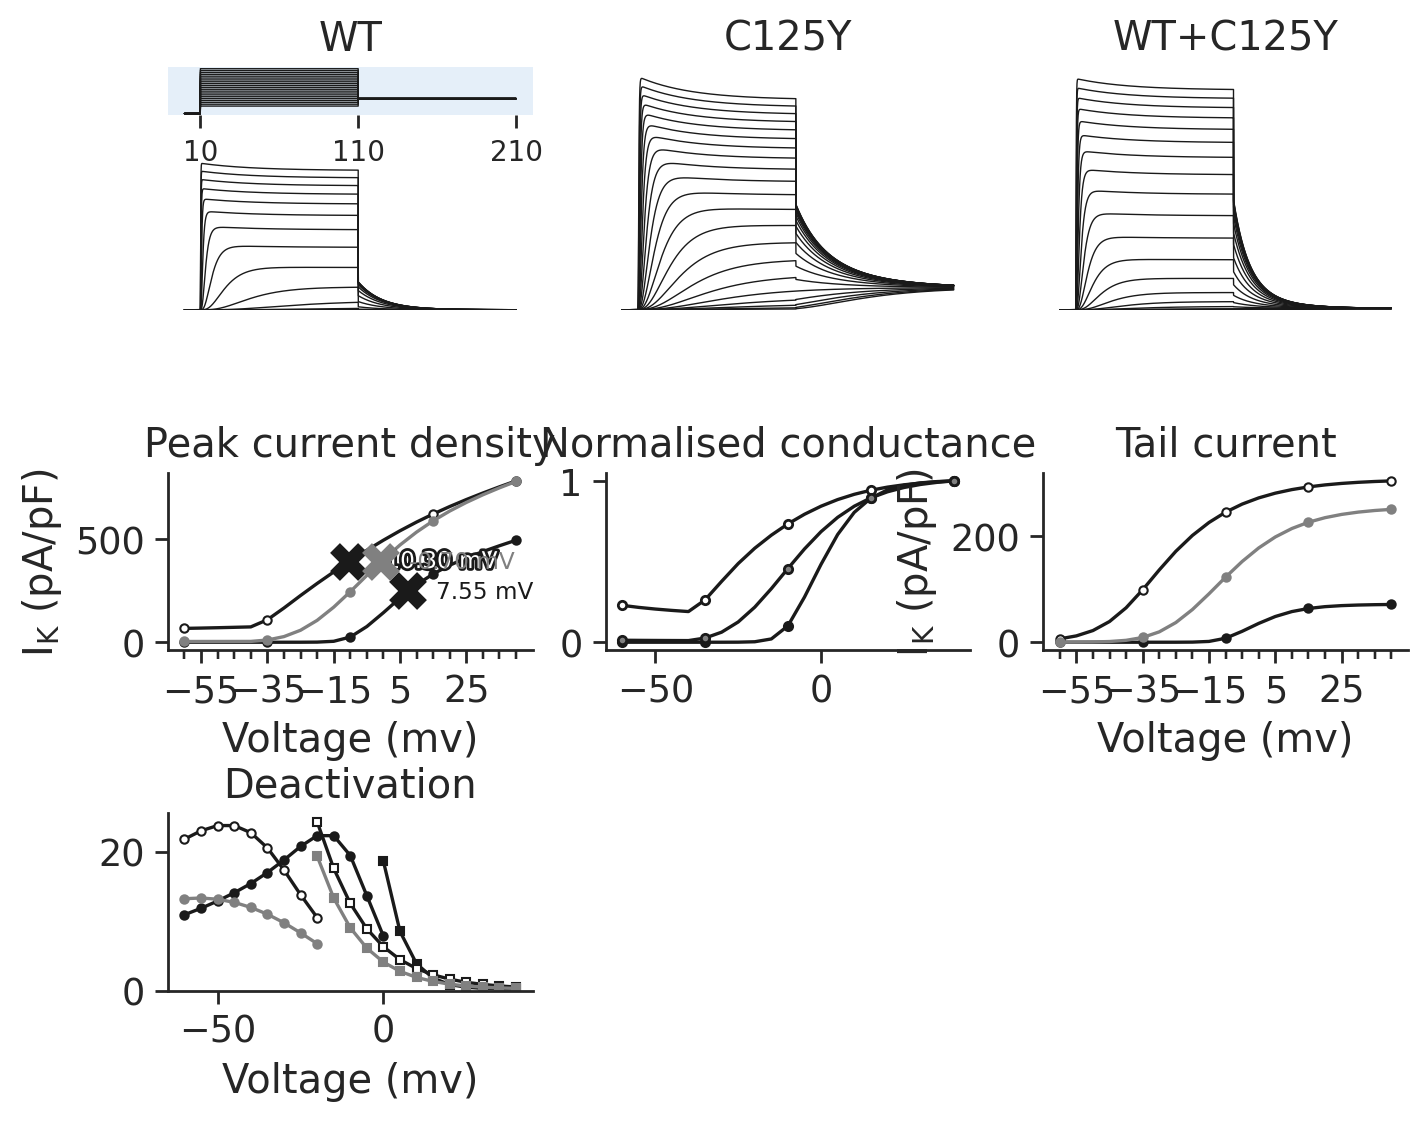

In [5]:
# plot the IV curves

# create a hashable dict for use with lru_cache


from collections import defaultdict
from matplotlib import patheffects


from typing import TypeVar, Generic
import pandas as pd

T = TypeVar("T", bound=pd.DataFrame)
U = TypeVar("U", bound=np.ndarray)
_K = TypeVar("_K")
_V = TypeVar("_V")


class HashWrapNDArray(Generic[U]):
    def __init__(self, arr: U):
        self.arr = arr

    def __eq__(self, other):
        return np.array_equal(self.arr, other.arr)

    def __hash__(self):
        return hash((tuple(self.arr.shape), tuple(self.arr.flatten())))


class HashWrapDataFrame(Generic[T]):
    def __init__(self, ser: T):
        self.ser = ser

    def __eq__(self, other):
        return self.ser.equals(other.ser)

    def __hash__(self):
        return hash((tuple(self.ser.index), hash(HashWrapNDArray(self.ser.values))))


class hashabledict(dict, Generic[_K, _V]):
    def __key(self):
        return tuple((k, self[k]) for k in sorted(self))

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        return self.__key() == other.__key()


result_type_alias = tuple[
    HashWrapDataFrame[pd.DataFrame],
    hashabledict[str, list[HashWrapNDArray]],
    HashWrapNDArray[np.ndarray],
    HashWrapNDArray[np.ndarray],
]


@lru_cache
def run_iv_figs(
    ppn_props: Optional[hashabledict] = None,
    ppn_mut_props: Optional[hashabledict] = None,
    ppn_mixed_props: Optional[hashabledict] = None,
    show_deact_traces: bool = False,
    fig_axs: Optional[tuple] = None,
    fig_axs_deact: Optional[tuple] = None,
    activation_result: Optional[result_type_alias] = None,
    deactivation_result: Optional[result_type_alias] = None,
    iv_calc_kwargs: Optional[hashabledict] = None,
    markersize_K=3,
    markersize_tau=3,
    markevery_tau=1,
    markevery_K=5,
    plot_mid_points: bool = True,
):
    """
    Run the point neurons (WT and mutant) for different step currents and generate a figure.

    The deactivation curve calculations are only shown if show_deact is True.

    :param ppn_props: properties for the WT point neuron
    :param ppn_mut_props: properties for the mutant point neuron
    :param show_deact: whether to show the deactivation curve calculations (step hyperpolarisations)


    """

    iv_calc_kwargs = iv_calc_kwargs or hashabledict()

    if ppn_props:
        assert isinstance(
            ppn_props, hashabledict
        ), "props must be hashable dicts to be cached"

    if activation_result:
        (
            points_wrap,
            sample_lines_wrap,
            t_np_wrap,
            plot_vclamp_values_wrap,
        ) = activation_result
        try:
            points = points_wrap.ser
            sample_lines = {
                k: [_v.arr for _v in v] for k, v in sample_lines_wrap.items()
            }
            t_np = t_np_wrap.arr
            plot_vclamp_values = plot_vclamp_values_wrap.arr
        except AttributeError:
            raise AttributeError(
                "Error unwrapping hashed dataframe or array. Did you wrap the activation result appropriately with HashWrapDataFrame and HashWrapNDArray?"
                " Expected format is (HashWrapDataFrame, hashabledict, HashWrapNDArray, HashWrapNDArray)"
            )
    else:
        ## Activation curve - step currents

        # Vclamp parameters
        vclamp.amp1 = vclamp_mut.amp1 = vclamp_mixed.amp1 = v_init
        #   amp2 will be changed by iv_calc
        vclamp.amp2 = vclamp_mut.amp2 = vclamp_mixed.amp2 = v_init
        vclamp.amp3 = vclamp_mut.amp3 = vclamp_mixed.amp3 = -40

        plot_vclamp_values = np.arange(-60, 45, 5)

        points, sample_lines = iv_calc(
            plot_vclamp_values,
            vclamp_target="amp2",
            ppn_props=ppn_props,
            ppn_mut_props=ppn_mut_props,
            ppn_mixed_props=ppn_mixed_props,
            **iv_calc_kwargs,
        )
        t_np = t_vec.as_numpy().copy()

    if deactivation_result:
        (
            deact_points_wrap,
            deact_sample_lines_wrap,
            t_np_deact_wrap,
            plot_deact_vclamp_values_wrap,
        ) = deactivation_result
        try:
            deact_points = deact_points_wrap.ser
            deact_sample_lines = {
                k: [_v.arr for _v in v] for k, v in deact_sample_lines_wrap.items()
            }
            t_np_deact = t_np_deact_wrap.arr
            plot_deact_vclamp_values = plot_deact_vclamp_values_wrap.arr
        except AttributeError:
            raise AttributeError(
                "Error unwrapping hashed dataframe or array. Did you wrap the deactivation result appropriately with HashWrapDataFrame and HashWrapNDArray?"
                " Expected format is (HashWrapDataFrame, hashabledict, HashWrapNDArray, HashWrapNDArray)"
            )
    else:
        ## Deactivation curve - variable step depolarisation
        #   reset vclamp
        vclamp.amp1 = vclamp_mut.amp1 = vclamp_mixed.amp1 = -100
        vclamp.amp2 = vclamp_mut.amp2 = vclamp_mixed.amp2 = 20
        #   this will now change by below
        vclamp.amp3 = vclamp_mut.amp3 = vclamp_mixed.amp3 = -40
        plot_deact_vclamp_values = np.arange(-60, 45, 5)
        deact_points, deact_sample_lines = iv_calc(
            plot_deact_vclamp_values,
            vclamp_target="amp3",
            ppn_props=ppn_props,
            ppn_mut_props=ppn_mut_props,
            ppn_mixed_props=ppn_mixed_props,
            **iv_calc_kwargs,
        )
        t_np_deact = t_vec.as_numpy().copy()

    if show_deact_traces:
        ##########
        # Deactivation Figure
        ##########
        if fig_axs_deact:
            fig_deact, axs_deact = fig_axs_deact
            assert len(axs_deact) == 4, "Expected 4 axes from 'fig_axs_deact' axs"
        else:
            sns.set_context("paper", font_scale=1.5)
            fig_deact, axs_deact = plt.subplots(nrows=4, gridspec_kw={"height_ratios": [0.1, 0.2, 1, 0.5]})  # type: ignore

        decay_idx = np.where(
            (t_np_deact > (vclamp.dur2 + vclamp.dur1))
            & (t_np_deact <= (vclamp.dur2 + vclamp.dur1 + vclamp.dur3))
        )[0]

        for v_line, ik_line, ik_mut_line, ik_mixed_line in zip(
            deact_sample_lines["v"],
            deact_sample_lines["ik"],
            deact_sample_lines["ik_mut"],
            deact_sample_lines["ik_mixed"],
        ):
            axs_deact[0].plot(t_np_deact, v_line, c="k", alpha=0.2, zorder=-1)
            axs_deact[1].plot(t_np_deact, ik_line, c="blue", alpha=0.5)
            axs_deact[1].plot(t_np_deact, ik_mut_line, c="orange", alpha=0.5)
            axs_deact[1].plot(t_np_deact, ik_mixed_line, c="green", alpha=0.5)
            for ik_np, c in zip(
                [ik_line, ik_mut_line, ik_mixed_line], ["blue", "orange", "green"]
            ):
                # find idx for 1/e of max
                tail_ik_np = ik_np[decay_idx]
                t_idx = int(
                    0.5 // h.dt
                )  # slight delay (in ms, converted to index) to check for decay
                tail_ik_np_range = np.abs(tail_ik_np - tail_ik_np[-1])
                idx = nearest_idx(
                    tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1)
                )
                tau = t_np_deact[decay_idx[0] + idx] - t_np_deact[decay_idx[0]]

                axs_deact[2].plot(
                    t_np_deact[decay_idx][int(0.5 // h.dt) :] - 110,
                    ik_np[decay_idx][int(0.5 // h.dt) :],
                    c=c,
                    label=f"{tau:.2f}",
                    alpha=0.5,
                )
                if plot_mid_points:
                    axs_deact[2].plot(
                        t_np_deact[
                            decay_idx[0]
                            + nearest_idx(
                                tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1)
                            )
                        ]
                        - 110,
                        ik_np[
                            decay_idx[0]
                            + nearest_idx(
                                tail_ik_np_range, tail_ik_np_range[t_idx] * np.exp(-1)
                            )
                        ],
                        "x",
                        c=c,
                    )

        sns.lineplot(
            data=deact_points,
            x="v",
            y="tau deactivation",
            hue="Kv3.2",
            ax=axs_deact[-1],
            palette=["blue", "orange", "green"],
        )

    ##########
    # General Figure
    ##########
    if fig_axs:
        fig, axs = fig_axs
    else:
        sns.set_context("paper", font_scale=1.5)

        fig, axs = plt.subplot_mosaic(
            [
                ["ik", "ik_mut", "ik_mixed"],
                ["ik", "ik_mut", "ik_mixed"],
                ["i-v peak", "g norm", "i-v tail"],
                ["tau", ".", "."],
            ],
            gridspec_kw={"height_ratios": [0.4, 0.5, 2, 2], "hspace": 1.5},
            dpi=200,
            figsize=(8, 6),
        )  # type: ignore

        axs["tau activation"] = axs["tau deactivation"] = axs["tau"]

        axs: dict[str, plt.Axes]

        # create inset axis
        axs["v"] = axs["ik"].inset_axes([0.0, 0.8, 1.0, 0.2])

    # plot sample lines
    c_options = defaultdict(
        lambda: "k",
        **{
            "mut": "white",
            "m": "white",
            "C125Y": "white",
            "mixed": "gray",
            "WT+C125Y": "gray",
        },
    )

    for key in sample_lines.keys():
        c = "gray" if "mut" in key else "k"
        v, *c_option = key.split("_")
        c_option.append("default")
        if c_option:
            c = c_options[c_option[0]]
        for i, line in enumerate(sample_lines[key]):
            axs[key].plot(t_np, line, lw=0.5, c="k")

    # take only vclamp values
    plot_points = points[points["v"].isin(plot_vclamp_values)]
    deact_plot_points = deact_points[deact_points["v"].isin(plot_deact_vclamp_values)]

    VOLTAGE_MV = "Voltage (mv)"

    sns.lineplot(
        data=plot_points,
        x="v",
        y="peak ik",
        ax=axs["i-v peak"],
        hue="Kv3.2",
        hue_order=["WT", "C125Y", "WT+C125Y"],
        palette=["k", "white", "gray"],
        marker="o",
        markeredgecolor="k",
        markersize=markersize_K,
        markevery=markevery_K,
        legend=False,
    )
    if "i-v tail" in axs:
        sns.lineplot(
            data=plot_points,
            x="v",
            y="tail ik",
            ax=axs["i-v tail"],
            hue="Kv3.2",
            hue_order=["WT", "C125Y", "WT+C125Y"],
            palette=["k", "white", "gray"],
            marker="o",
            markeredgecolor="k",
            markersize=markersize_K,
            markevery=markevery_K,
            legend=False,
        )

    # plot voltage at half peak
    for nrn, c in zip([ppn, ppn_mut, ppn_mixed], ["k", "white", "gray"]):
        key = nrn.name()
        df_kv = points[points["Kv3.2"] == key].reset_index()
        # normalise
        # g = I/(V-Ek)
        g = df_kv["peak ik"] / (df_kv["v"] - nrn.ek)
        g[g.isin([np.nan, np.inf, -np.inf])] = 0
        g_max = g.max()
        df_kv["Relative conductance"] = g / g_max
        interp_points = interpolate(df_kv, 0.01)

        if plot_mid_points:
            v_half_idx, v_half = find_v_half(interp_points)
            # print(f"{v_half=}")
            xy = (v_half, interp_points.iloc[v_half_idx]["peak ik"])
            axs["i-v peak"].annotate(
                f"{xy[0]:.2f} mV",
                xy=xy,
                xytext=(10, 0),
                textcoords="offset points",
                color=c,
                path_effects=[patheffects.withStroke(linewidth=2, foreground="k")]
                if c == "white"
                else None,
                # arrowprops=dict(arrowstyle="->", color="k"),
                va="center",
                fontsize="xx-small",
            )

            axs["i-v peak"].plot(
                *xy, "x", color=c, markersize=10, markeredgewidth=5, zorder=100
            )

        if "g norm" in axs:
            axs["g norm"].plot(
                df_kv["v"],
                df_kv["Relative conductance"],
                c="k",
                label=key,
                marker="o",
                markerfacecolor=c,
                markeredgecolor="k",
                markersize=markersize_K,
                markevery=markevery_K,
            )

    axs["v"].set_ylim(env_var()["v_init"] - 5, max(plot_vclamp_values) + 5)
    # set ylims the same for ik and ikmut
    ymax = max(
        axs["ik"].get_ylim()[1],
        axs["ik_mut"].get_ylim()[1],
        axs["ik_mixed"].get_ylim()[1],
    )
    for ax in [axs["ik"], axs["ik_mut"], axs["ik_mixed"]]:
        ax.set_ylim(0, ymax)

    axs["ik"].set_title(ppn.name())
    axs["ik_mut"].set_title(ppn_mut.name())
    axs["ik_mixed"].set_title(ppn_mixed.name())

    axs["i-v peak"].set_title("Peak current density")
    if "i-v tail" in axs:
        axs["i-v tail"].set_title("Tail current")
    if "g norm" in axs:
        axs["g norm"].set_title("Normalised conductance")

    for ax in [axs["v"], axs["ik"], axs["ik_mut"], axs["ik_mixed"]]:
        sns.despine(ax=ax, left=True, bottom=True)
        ax.set(yticks=[], xticks=[])

    xticks = [
        vclamp.dur1,
        vclamp.dur1 + vclamp.dur2,
        vclamp.dur1 + vclamp.dur2 + vclamp.dur3,
    ]
    axs["v"].set_xticks(xticks)
    axs["v"].set_xticklabels(np.array(xticks, dtype=int), fontsize="x-small")

    # sns.despine(ax=axs["v"], top=False, right=False)
    pal = sns.color_palette("Blues", n_colors=10)
    axs["v"].set_facecolor(pal[0])

    axs_iv = (
        [axs["i-v peak"], axs["i-v tail"]] if "i-v tail" in axs else [axs["i-v peak"]]
    )
    for ax in axs_iv:
        ax.set_xlabel(VOLTAGE_MV)
        if ax == axs["i-v peak"] or ax == axs["i-v tail"]:
            ax.set_ylabel("$\\rm{I_{K}}$ (pA/pF)")
        elif ax == axs["g norm"]:
            ax.set_ylabel("G/Gmax")
        else:
            ax.set_ylabel("")
        ax.set_xticks(plot_points["v"], minor=True)
        ax.set_xticks(
            np.arange(plot_vclamp_values.min() + 5, plot_vclamp_values.max() + 5, 20),
            minor=False,
        )

    tau_v_plot_points = {"WT": 0, "C125Y": -20, "WT+C125Y": -20}

    for i, key in enumerate(["tau activation", "tau deactivation"]):
        if "deactivation" in key:
            tau_plot_points = deact_plot_points[
                (
                    (
                        (deact_plot_points["v"] <= tau_v_plot_points["WT"])
                        & (deact_plot_points["Kv3.2"] == "WT")
                    )
                    | (
                        (deact_plot_points["v"] <= tau_v_plot_points["C125Y"])
                        & (deact_plot_points["Kv3.2"] == "C125Y")
                    )
                    | (
                        (deact_plot_points["v"] <= tau_v_plot_points["WT+C125Y"])
                        & (deact_plot_points["Kv3.2"] == "WT+C125Y")
                    )
                )
            ]
        else:
            tau_plot_points = plot_points[
                (
                    (
                        (plot_points["v"] >= tau_v_plot_points["WT"])
                        & (plot_points["Kv3.2"] == "WT")
                    )
                    | (
                        (plot_points["v"] >= tau_v_plot_points["C125Y"])
                        & (plot_points["Kv3.2"] == "C125Y")
                    )
                    | (
                        (plot_points["v"] >= tau_v_plot_points["WT+C125Y"])
                        & (plot_points["Kv3.2"] == "WT+C125Y")
                    )
                )
            ]

        sns.lineplot(
            data=tau_plot_points,
            x="v",
            y=key,
            ax=axs[key],
            hue="Kv3.2",
            hue_order=["WT", "C125Y", "WT+C125Y"],
            palette=["k", "white", "gray"],
            marker="o" if "deactivation" in key else "s",
            markeredgecolor="k",
            markersize=markersize_tau,
            markevery=markevery_tau,
            legend=False,
        )
        axs[key].set_title(key.replace("tau ", "").capitalize())
        axs[key].set_xlabel(VOLTAGE_MV)
        if key == "tau activation":
            axs[key].set_ylabel(f"$\\tau$ (ms)")
        else:
            axs[key].set_ylabel("")

    if axs["tau activation"] != axs["tau deactivation"]:
        axs["tau activation"].set_xlim(-20, 40)
    axs["tau deactivation"].set_ylim(0)

    # change white lines to black
    for ax in axs.values():
        for line in ax.lines:
            if line.get_color() == "white":
                line.set_color("k")
                line.set_markerfacecolor("w")
            else:
                line.set_markeredgecolor(line.get_color())

    # axs["tau deactivation"].set_yticks([0, 10, 20, 30, 40, 60])
    return fig, axs


run_iv_figs()

### Playground


In [6]:
# Widgets
%matplotlib inline
from IPython.display import clear_output

set_seg_prop(ppn, "ek", -120)
set_seg_prop(ppn_mut, "ek", -120)

# ppn_props = dict(iv_shift=-2.11, iv_gain=-9.7, tau_scale=20, tau_shift=10.0, tau_gain=8)
# ppn_mut_props = dict(iv_shift=-20.0, iv_gain=-10.2, tau_scale=28, tau_shift=-10.0, tau_gain=6)

ppn_props = dict(
    theta_m=-13.0,
    k_m=7.8,
    tau_m0=0.1,
    tau_m1=80.0,
    phi_m0=-20.0,
    phi_m1=-13.0,
    sigma_m0=60.0,
    sigma_m1=-6.0,
)

ppn_mut_props = dict(
    theta_m = -50.0,
    k_m = 15,
    tau_m0 = 0.1,
    tau_m1 = 80,
    phi_m0 = -45.0,
    phi_m1 = -45.0,
    sigma_m0 = 100.0,
    sigma_m1 = -14.0,
)

range_props = dict(
    theta_m=(-100, 100),
    k_m=(-5, 20),
    tau_m0=(0.1, 100),
    tau_m1=(-100, 100),
    phi_m0=(-100, 100),
    phi_m1=(-100, 100),
    sigma_m0=(-100, 400),
    sigma_m1=(-20, 0),
)
output = widgets.Output()

ppn_mut_props_orig = ppn_mut_props.copy()

def on_change(change_slider):
    with output:
        ppn_mut_props[change_slider.owner.description] = change_slider.new

        print(ppn_mut_props)

        fig, axs= run_iv_figs(hashabledict(ppn_mut_props_orig), hashabledict(ppn_mut_props))
        fig.suptitle(str(ppn_mut_props), fontsize='x-small')
        clear_output()
        display(fig)
        plt.close(fig)

# create float slider per parameter
sliders = []
for key, value in range_props.items():
    slider =widgets.FloatSlider(
            value=ppn_mut_props[key],
            min=value[0],
            max=value[1],
            step=0.1 if key in ["k_m", "tau_m"] else 1,
            description=key,
            continuous_update=False,
            readout=True,
            readout_format=".1f",
        )
    slider.observe(on_change, names="value") # type: ignore
    sliders.append(slider)

# add button to reset to original values
def on_reset(b):
    ppn_mut_props.update(ppn_mut_props_orig)
    with output:
        clear_output()
        for slider in sliders:
            slider: widgets.FloatSlider
            slider.value = ppn_mut_props[slider.description]
            # slider.notify_change({"name": "value", "old": None, "new": slider.value, "owner": slider})
            # print(ppn_mut_props)

button = widgets.Button(description="Reset")
button.on_click(on_reset)

box = widgets.VBox(sliders + [button])
display(box, output)

Output()

## PV Interneuron


In [7]:
pv = get_pv("param check", 1000, 30, 1, 60)
pv_mixed = get_pv_mixed("param check mixed", 1000, 30, 1, 60)

mechs = []
for sec in pv.node:
    for seg in sec:
        for mech in seg:
            mechs.append(mech.name())
        break
    break
if "Kv3" in mechs:
    mech_type = "Kv3"
elif "SKv3_1" in mechs:
    mech_type = "SKv3_1"
else:
    raise ValueError("Kv3.2 mechanism not found")

props_to_find_dict = {
    "Kv3": [
        "theta_m",
        "k_m",
        "tau_m0",
        "tau_m1",
        "phi_m0",
        "phi_m1",
        "sigma_m0",
        "sigma_m1",
    ],
    "SKv3_1": ["iv_shift", "iv_gain", "tau_scale", "tau_shift", "tau_gain"],
}
props_to_find = props_to_find_dict[mech_type]
pv_props = {}
pv_mut_props = {}
pv_mixed_props = {}

for _pv in [pv, pv_mixed]:
    for sec in _pv.node:
        for seg in sec:
            for mech in seg:
                if mech.name() == mech_type:
                    for prop in props_to_find:
                        pv_props[prop] = getattr(mech, prop)
                elif mech.name() == mech_type + "m":
                    for prop in props_to_find:
                        pv_mut_props[prop] = getattr(mech, prop)
                elif mech.name() == mech_type + "mixed":
                    for prop in props_to_find:
                        pv_mixed_props[prop] = getattr(mech, prop)
            break
        break

print(f"Mechanism type: {mech_type}")
print(f"Wild-type properties: {pv_props}")
print(f"Mutant properties: {pv_mut_props}")
print(f"WT + Mutant properties: {pv_mixed_props}")

remove_cell_from_neuron(pv)
remove_cell_from_neuron(pv_mixed)

Mechanism type: Kv3
Wild-type properties: {'theta_m': -13.0, 'k_m': 7.8, 'tau_m0': 0.1, 'tau_m1': 80.0, 'phi_m0': -20.0, 'phi_m1': -13.0, 'sigma_m0': 60.0, 'sigma_m1': -6.0}
Mutant properties: {'theta_m': -50.0, 'k_m': 15.0, 'tau_m0': 0.1, 'tau_m1': 80.0, 'phi_m0': -45.0, 'phi_m1': -45.0, 'sigma_m0': 100.0, 'sigma_m1': -14.0}
WT + Mutant properties: {'theta_m': -30.0, 'k_m': 13.0, 'tau_m0': 0.1, 'tau_m1': 80.0, 'phi_m0': -20.0, 'phi_m1': -45.0, 'sigma_m0': 100.0, 'sigma_m1': -12.0}


### F-I curve


In [8]:
from src.data.files import get_cache_root
import hashlib

stims = [(amp, 0) for amp in np.round(np.arange(0.0, 4.1, 0.1), 3)]

fractions = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.5]
fractions = [0, 0.10, 0.25, 0.3, 0.4, 0.5]

dur = 250

# hash stims, fractions, and dur
# this allows us to load the summary dataframe directly from cache
hashed = hashlib.md5(str((stims, fractions, dur)).encode("utf-8")).hexdigest()

ap_file = get_cache_root() / f"ap-{hashed}.h5"

if not ap_file.exists():
    default_amp_result = run_sims(
        "default", stims, fractions, dur=dur, load=True, print_props=True
    )

    ap_df = pd.DataFrame()
    for key, val in default_amp_result.items():
        nrn_name = key[: key.find("_")]
        frac = val[KVMUT_FRAC_LABEL]
        current = val[CURRENT_LABEL]
        ap_soma = val["APCount"]["soma"].n
        ap_ais = val["APCount"]["init"].n
        ap_axon = val["APCount"]["comm"].n

        ap_df = pd.concat(
            [
                ap_df,
                pd.DataFrame(
                    {
                        KVMUT_FRAC_LABEL: frac,
                        CURRENT_LABEL: current,
                        "Neuron": nrn_name,
                        "loc": ["soma", "AIS", "axon"],
                        "Spikes": [ap_soma, ap_ais, ap_axon],
                    },
                ),
            ],
            ignore_index=True,
        )
    ap_df.to_hdf(ap_file, "df")

ap_df = pd.read_hdf(ap_file, "df")

ap_df

,Kv3.2 mutant fraction,Current (nA),Neuron,loc,Spikes
0,0.0,0.0,WT,soma,0.0
1,0.0,0.0,WT,AIS,0.0
2,0.0,0.0,WT,axon,0.0
3,0.1,0.0,C125Y - 10%,soma,0.0
4,0.1,0.0,C125Y - 10%,AIS,0.0
...,...,...,...,...,...
733,0.4,4.0,C125Y - 40%,AIS,2.0
734,0.4,4.0,C125Y - 40%,axon,2.0
735,0.5,4.0,C125Y - 50%,soma,2.0
736,0.5,4.0,C125Y - 50%,AIS,2.0


possible props for Kv3mixed: ['gmax', 'h', 'h0', 'iKv3', 'ik', 'is_ion', 'k_h', 'k_m', 'm', 'name', 'phi_h', 'phi_m0', 'phi_m1', 'segment', 'sigma_h0', 'sigma_h1', 'sigma_m0', 'sigma_m1', 'tau_h0', 'tau_h1', 'tau_m0', 'tau_m1', 'theta_h', 'theta_m']
Wild-type + Mutant properties: {'theta_m': -30.0, 'k_m': 13.0, 'tau_m0': 0.1, 'tau_m1': 80.0, 'phi_m0': -20.0, 'phi_m1': -45.0, 'sigma_m0': 100.0, 'sigma_m1': -12.0}
possible props for Kv3: ['gmax', 'h', 'h0', 'iKv3', 'ik', 'is_ion', 'k_h', 'k_m', 'm', 'name', 'phi_h', 'phi_m0', 'phi_m1', 'segment', 'sigma_h0', 'sigma_h1', 'sigma_m0', 'sigma_m1', 'tau_h0', 'tau_h1', 'tau_m0', 'tau_m1', 'theta_h', 'theta_m']
Wild-type properties: {'theta_m': -13.0, 'k_m': 7.8, 'tau_m0': 0.1, 'tau_m1': 80.0, 'phi_m0': -20.0, 'phi_m1': -13.0, 'sigma_m0': 60.0, 'sigma_m1': -6.0}


<AxesSubplot: xlabel='Current (nA)', ylabel='Firing rate (Hz)'>

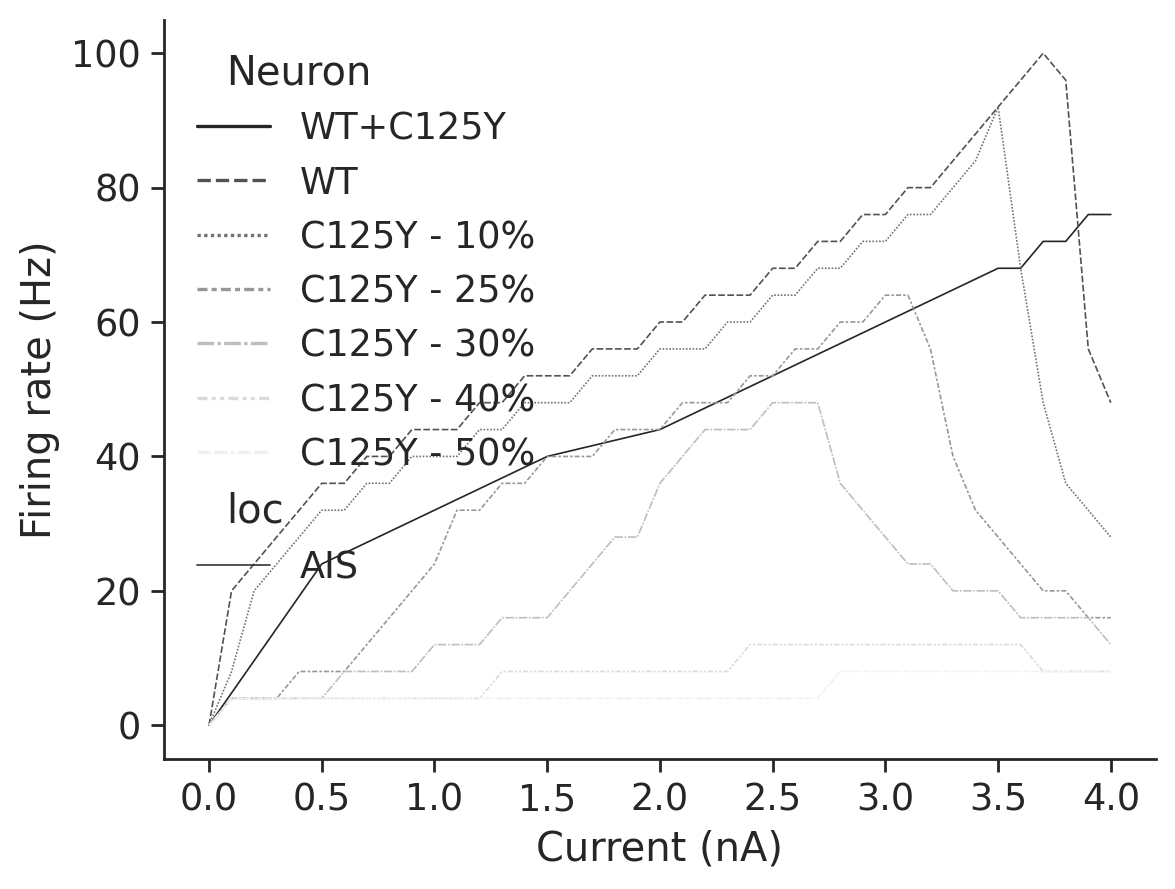

In [9]:
stims = [
    (amp, 0)
    for amp in sorted(
        set(
            np.append(
                np.round(np.arange(0.0, 4.1, 0.5), 3),
                np.round(np.arange(3.5, 4.1, 0.1), 3),
            )
        )
    )
]


ap_df = pd.read_hdf(ap_file, "df")

_adjusted_pv_mixed_props = {
    "theta_m": -30.0,
    "k_m": 13,
    "tau_m0": 0.1,
    "tau_m1": 80.0,
    "phi_m0": -20.0,
    "phi_m1": -45.0,
    "sigma_m0": 100.0,
    "sigma_m1": -12.0,
}


mixed_name = hashlib.md5(str(_adjusted_pv_mixed_props).encode("utf-8")).hexdigest()
default_mixed_name = hashlib.md5(str(pv_mixed_props).encode("utf-8")).hexdigest()
if mixed_name == default_mixed_name:
    _adjusted_pv_mixed_props = None  # don't pass as arg, for quicker sims
else:
    mixed_name = "test"
    _adjusted_pv_mixed_props = {
        k + "_Kv3mixed": v for k, v in _adjusted_pv_mixed_props.items()
    }

amp_result = run_sims(
    f"{mixed_name}-mixed",
    stims,
    [1],
    dur=dur,
    load=True,
    arrow=False,
    pv_props=_adjusted_pv_mixed_props,
    print_props=True,
)
dfs = []
for key, val in amp_result.items():
    nrn_name = key[: key.find("_")]
    frac = val[KVMUT_FRAC_LABEL]
    current = val[CURRENT_LABEL]
    ap_soma = val["APCount"]["soma"].n
    ap_ais = val["APCount"]["init"].n
    ap_axon = val["APCount"]["comm"].n

    df = pd.DataFrame(
        {
            KVMUT_FRAC_LABEL: frac,
            CURRENT_LABEL: current,
            "Neuron": nrn_name,
            "loc": ["soma", "AIS", "axon"],
            "Spikes": [ap_soma, ap_ais, ap_axon],
        },
    )
    dfs.append(df)
ap_df = pd.concat([*dfs, ap_df], ignore_index=True)
ap_df[FIRING_RATE_LABEL] = ap_df["Spikes"] / (dur / 1000)

sns.lineplot(
    data=ap_df,
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="Neuron",
    style="Neuron",
    palette="Greys_r",
    size="loc",
    size_order=["AIS"],
)

### Adjust Kv3.2 params

> note: if the kernel dies, try _only_ importing libraries, or just use cached values for PV sims above (don't create NEURON objects)


In [10]:
stims = [(amp, 0) for amp in np.round(np.arange(0.0, 4.1, 0.1), 3)]

# either change params of the original Kv3.2 channel ("down")
# or the mutated Kv3.2 channel ("up")
# the number is the fraction of Kv3.2 that is the mutant channel (0.25 = 25%)
mut_directions = {"up": [0.25], "down": [0]}

num_spaces = 11
params = {}
# params (values are default -> mutant)
for key, val in pv_mut_props.items():
    if pv_props[key] == val:
        # if the same, add 20% value either side
        params[key] = np.round(
            np.linspace(0.8 * pv_props[key], 1.2 * pv_props[key], num_spaces), 2
        )
    else:
        params[key] = np.round(np.linspace(pv_props[key], val, num_spaces), 2)

param_df = pd.DataFrame()
dur = 250
pbar = tqdm(
    list(product(mut_directions.items(), params.items())),
    desc=f"up/down |> params ({len(params)*num_spaces}) |> fraction=PV name_(stim)_duration",
)

for (mut_up_down, fracs), (param_key, param_space) in pbar:
    if isinstance(param_key, tuple):
        actual_params = [f"{pk}_{mech_type}" for pk in param_key]
    else:
        actual_params = [f"{param_key}_{mech_type}"]

    if mut_up_down == "up":
        actual_params = [f"{p}m" for p in actual_params]
    param_name = " ".join(actual_params)

    length = (
        len(param_space) if not np.iterable(param_space[0]) else len(param_space[0])
    )

    for i in range(length):
        if np.iterable(param_space[0]):
            pv_props = {p: v[i] for p, v in zip(actual_params, param_space)}
        else:
            pv_props = {p: param_space[i] for p in actual_params}

        param_val = tuple(pv_props.values())
        if len(param_val) == 1:
            param_val = param_val[0]
        else:
            param_val = " ".join([str(v) for v in param_val])

        # join dict as string
        pv_key = " ".join([f"{k}={v}" for k, v in pv_props.items()])

        param_result = run_sims(
            pv_key,
            stims,
            fracs,
            dur=dur,
            load=True,
            arrow=False,
            shape_plot=False,  # quicker running/saving/loading but no voltage traces
            pv_props=pv_props,  # change params
            pbar_prefix=f"{mut_up_down}|>{param_key}",
        )

        for key, val in param_result.items():
            nrn_name = key[: key.find("_")]
            frac = val[KVMUT_FRAC_LABEL]
            current = val[CURRENT_LABEL]
            ap_soma = val["APCount"]["soma"].n
            ap_ais = val["APCount"]["init"].n
            ap_axon = val["APCount"]["comm"].n

            param_df = pd.concat(
                [
                    param_df,
                    pd.DataFrame(
                        {
                            "param": param_name,
                            "value": param_val,
                            param_key: param_val,
                            "mutation direction": mut_up_down,
                            KVMUT_FRAC_LABEL: frac,
                            CURRENT_LABEL: current,
                            "Neuron": nrn_name,
                            "loc": ["soma", "AIS", "axon"],
                            "Spikes": [ap_soma, ap_ais, ap_axon],
                        },
                    ),
                ],
                ignore_index=True,
            )
param_df[FIRING_RATE_LABEL] = param_df["Spikes"] / (dur / 1000)
param_df

up/down |> params (88) |> fraction=PV name_(stim)_duration:   0%|          | 0/16 [00:00<?, ?it/s]

up/down |> params (88) |> fraction=PV name_(stim)_duration: 100%|██████████| 16/16 [00:49<00:00,  3.11s/it]


,param,value,theta_m,mutation direction,Kv3.2 mutant fraction,Current (nA),Neuron,loc,Spikes,k_m,tau_m0,tau_m1,phi_m0,phi_m1,sigma_m0,sigma_m1,Firing rate (Hz)
0,theta_m_Kv3m,-13.0,-13.0,up,0.25,0.0,C125Y - 25%,soma,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,theta_m_Kv3m,-13.0,-13.0,up,0.25,0.0,C125Y - 25%,AIS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,theta_m_Kv3m,-13.0,-13.0,up,0.25,0.0,C125Y - 25%,axon,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,theta_m_Kv3m,-13.0,-13.0,up,0.25,0.1,C125Y - 25%,soma,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
4,theta_m_Kv3m,-13.0,-13.0,up,0.25,0.1,C125Y - 25%,AIS,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21643,sigma_m1_Kv3,-14.0,NaN,down,0.00,3.9,WT,AIS,7.0,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,28.0
21644,sigma_m1_Kv3,-14.0,NaN,down,0.00,3.9,WT,axon,8.0,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,32.0
21645,sigma_m1_Kv3,-14.0,NaN,down,0.00,4.0,WT,soma,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,4.0
21646,sigma_m1_Kv3,-14.0,NaN,down,0.00,4.0,WT,AIS,8.0,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,32.0


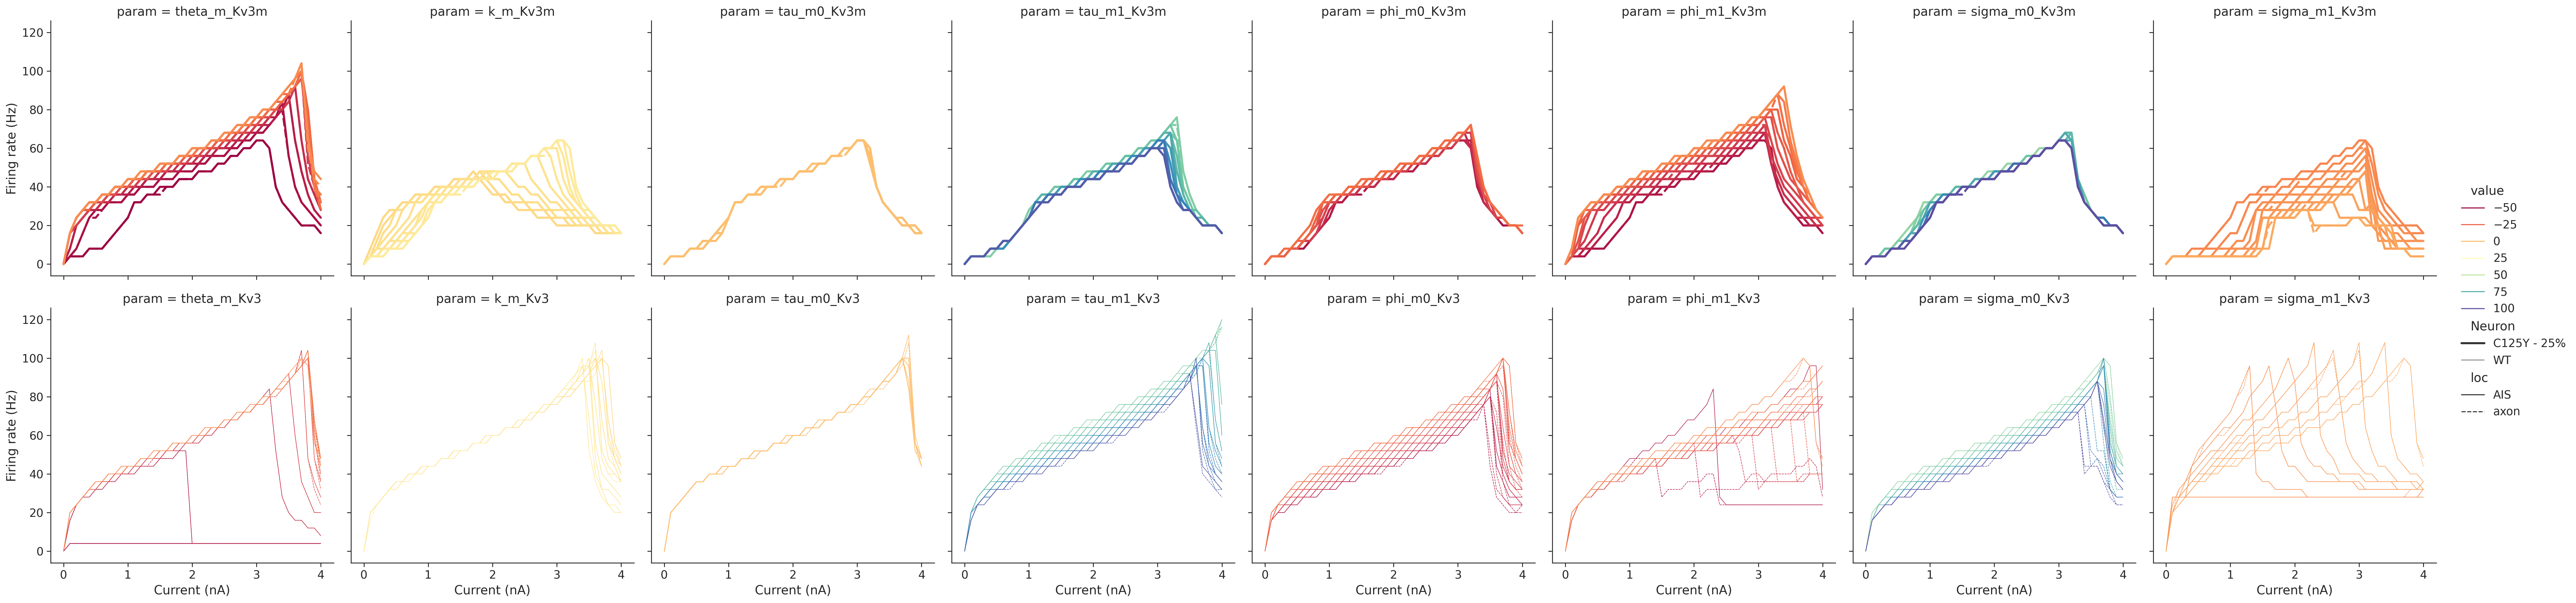

In [11]:
sns.relplot(
    data=param_df,
    col="param",
    col_wrap=len(params),
    # row="Neuron",
    hue="value",
    palette="Spectral",
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    size="Neuron",
    style="loc",
    style_order=["AIS", "axon"],
    kind="line",
    legend="brief",
    # facet_kws=dict(sharex=False),
)

/tmp/ipykernel_3923023/2478023303.py:53: UserWarning: The palette list has more values (11) than needed (5), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_3923023/2478023303.py:53: UserWarning: The palette list has more values (11) than needed (5), which may not be intended.
  sns.lineplot(


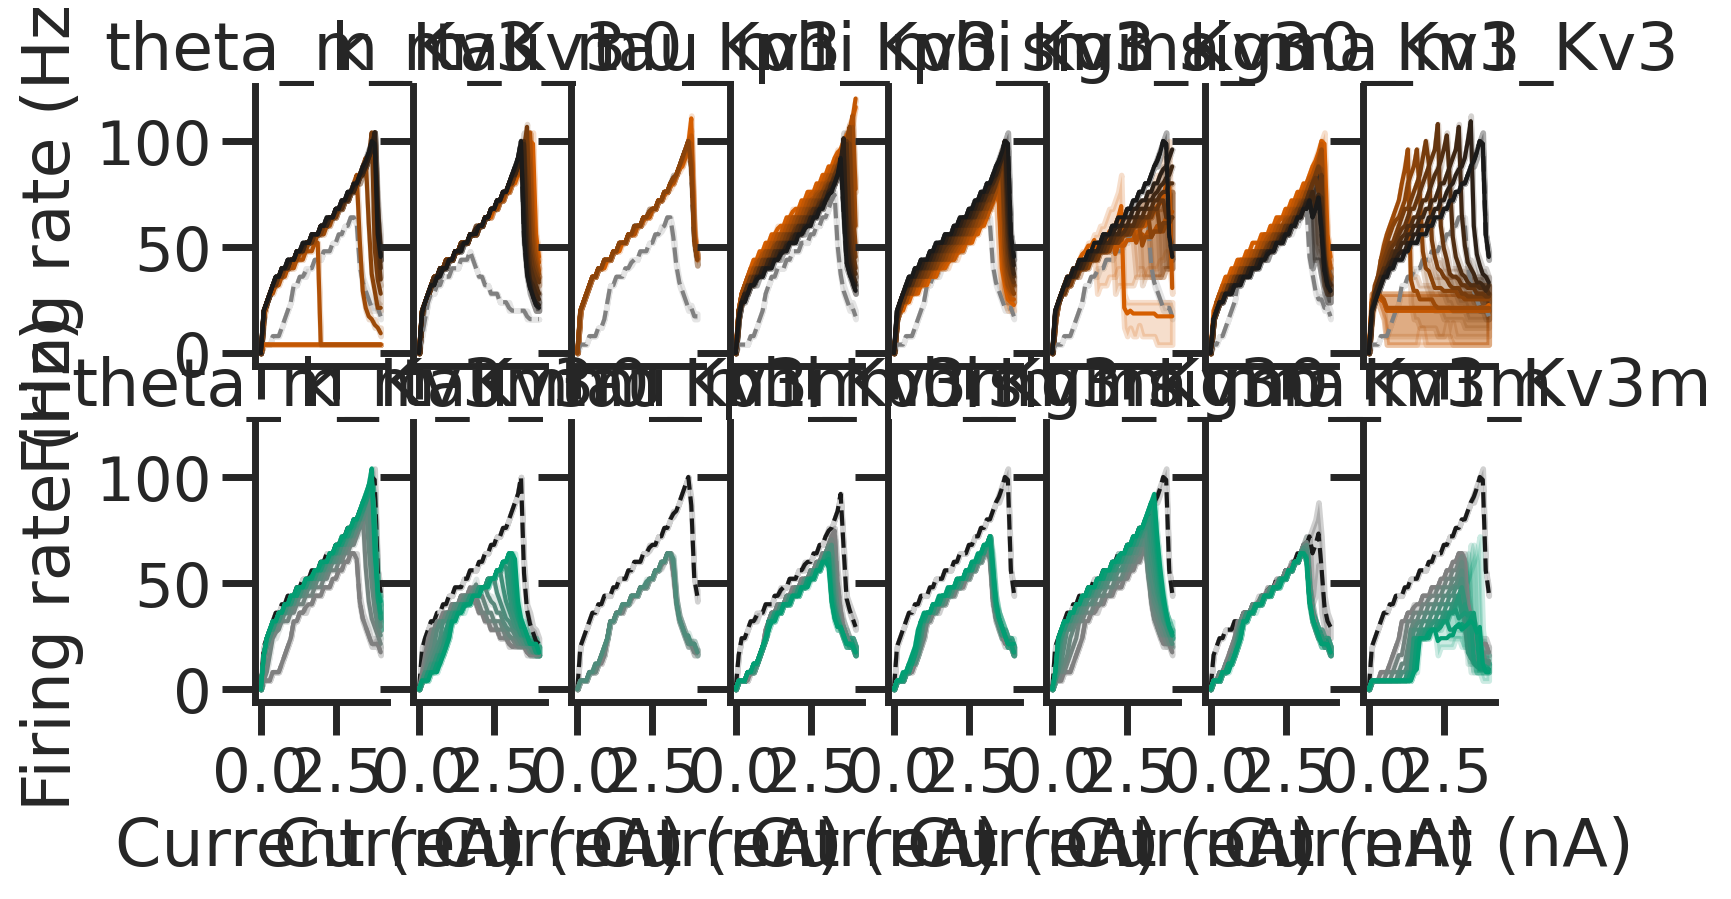

In [12]:
with sns.plotting_context("poster"):
    fig, axs = plt.subplot_mosaic(
        [
            [
                f"{p}_{mech_type}" for p in props_to_find
            ],  # how normal channels can be impacted
            [
                f"{p}_{mech_type}m" for p in props_to_find
            ],  # how pathological channels can be repaired
        ],
        sharey=True,
        sharex=True,
        figsize=(8, 4),
    )

    base_kwargs = dict(
        x=CURRENT_LABEL,
        y=FIRING_RATE_LABEL,
        # style="loc",
        # style_order=["AIS"],
        size="Neuron",
    )

    for i, (key, ax) in enumerate(axs.items()):
        col = key.replace(f"_{mech_type}m", "").replace(f"_{mech_type}", "")
        pal = (
            sns.blend_palette(["grey", "g"], n_colors=len(params[col]))
            if "Kv3m" in key
            else sns.blend_palette(["r", "k"], n_colors=len(params[col]))
        )
        sns.lineplot(
            data=param_df[
                (param_df[col] == param_df[col].min())
                & (param_df["mutation direction"] == "up")
            ],
            **base_kwargs,
            color="grey",
            ax=ax,
            linestyle="--",
            legend=False,
        )
        sns.lineplot(
            data=param_df[
                (param_df[col] == param_df[col].max())
                & (param_df["mutation direction"] == "down")
            ],
            **base_kwargs,
            color="k",
            ax=ax,
            linestyle="--",
            legend=False,
        )
        sns.lineplot(
            data=param_df[param_df["param"] == key],
            ax=ax,
            hue="value",
            palette=pal,
            **base_kwargs,
            # legend=(i == 0),
            legend=False,
        )
        ax.set_title(key)

### Example trace


WT had 59.0 spikes at the AIS.
C125Y - 25% had 43.0 spikes at the AIS.
C125Y - 50% had 1.0 spikes at the AIS.
WT + C125Y had 44.0 spikes at the AIS.


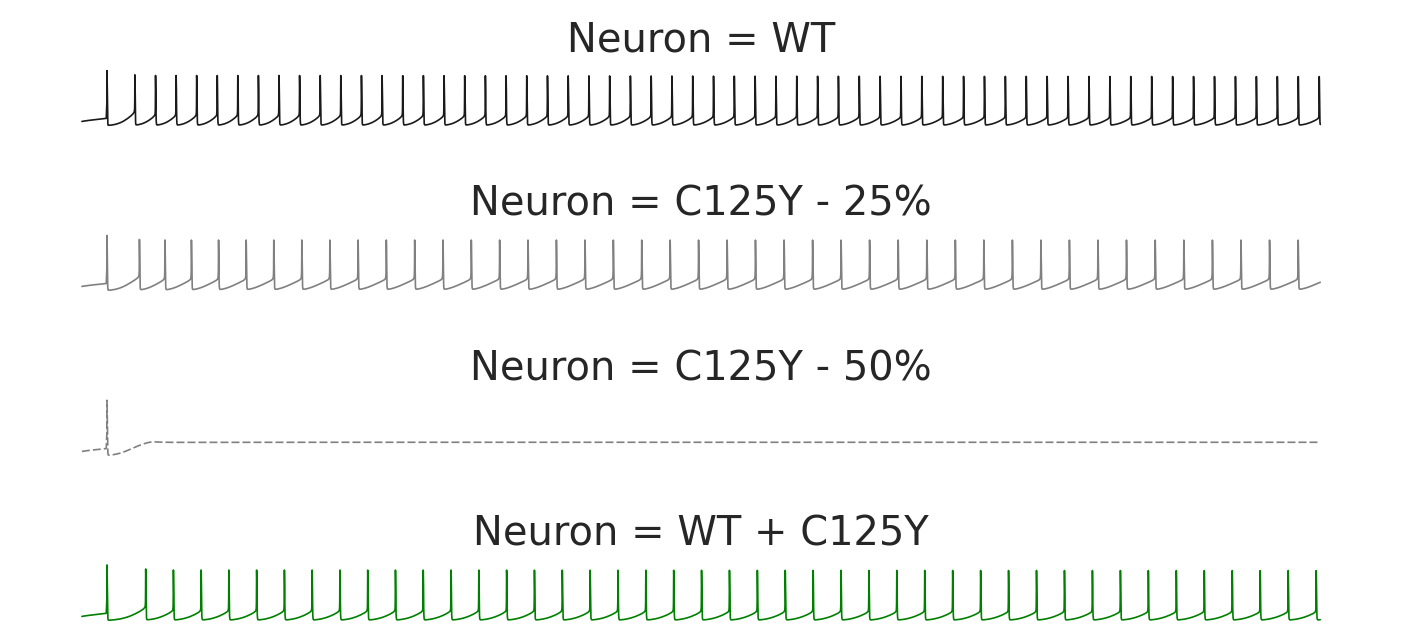

In [13]:
amp = 2.0  # nA
dur = 1000  # ms

pv_wt = get_pv("WT")

pv_mut_1 = get_pv("C125Y - 25%")
pv_mut_1.biophys()
mut(pv_mut_1, 0.25)

pv_mut_half = get_pv("C125Y - 50%")
pv_mut_half.biophys()
mut(pv_mut_half, 0.5)

pv_mixed = get_pv_mixed("WT + C125Y")
pv_mixed.biophys()
mut(pv_mixed, 1)

# create datafrome for voltage at nodes
v_df = pd.DataFrame()
pv_nrns = [
    pv_wt,
    pv_mut_1,
    pv_mut_half,
    pv_mixed,
    # pv_mut_3_4, pv_mut_half, pv_mut_quart
]
for nrn in pv_nrns:
    # set_nrn_prop(nrn, "ek", -85, ignore_error=True)
    AP, x_df = get_cached_df(nrn.name, nrn, amp, dur, shape_plot=True)
    soma = x_df.iloc[:, 0]
    tip = x_df.iloc[:, -1]

    ais_columns = sorted(set([(a, x) for a, x in x_df.columns if "axon" in a]))
    ais_v = x_df[ais_columns[-1]]

    ap_soma = AP["soma"].n
    ap_ais = AP["init"].n
    ap_axon = AP["comm"].n

    nrn_name = nrn.name[: nrn.name.find("(")].replace("test", "")
    print(f"{nrn_name} had {ap_ais} spikes at the AIS.")

    v_df = pd.concat(
        [
            v_df,
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: tip.values,
                    TIME_LABEL: tip.index,
                    "Neuron": nrn_name,
                    "loc": "axon",
                },
            ),
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: soma.values,
                    TIME_LABEL: soma.index,
                    "Neuron": nrn_name,
                    "loc": "soma",
                },
            ),
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: ais_v.values,
                    TIME_LABEL: ais_v.index,
                    "Neuron": nrn_name,
                    "loc": "AIS",
                },
            ),
        ],
        ignore_index=True,
    )

g = sns.relplot(
    data=v_df,
    x=TIME_LABEL,
    y=VOLTAGE_LABEL,
    hue="Neuron",
    hue_order=[nrn.name[: nrn.name.find("(")].replace("test", "") for nrn in pv_nrns],
    palette=["k", "grey", "grey", "green"],
    style="Neuron",
    dashes=["", "", (4.8, 1.8), ""],
    size="loc",
    size_order=["AIS"],
    legend=False,
    aspect=8,
    height=1,
    row="Neuron",
    kind="line",
)
# remove borders, labels, and ticks
sns.despine(left=True, bottom=True)
g.set(xlabel="", ylabel="", xticks=[], yticks=[])

for nrn in pv_nrns:
    remove_cell_from_neuron(nrn)

(0.0, 200.0)

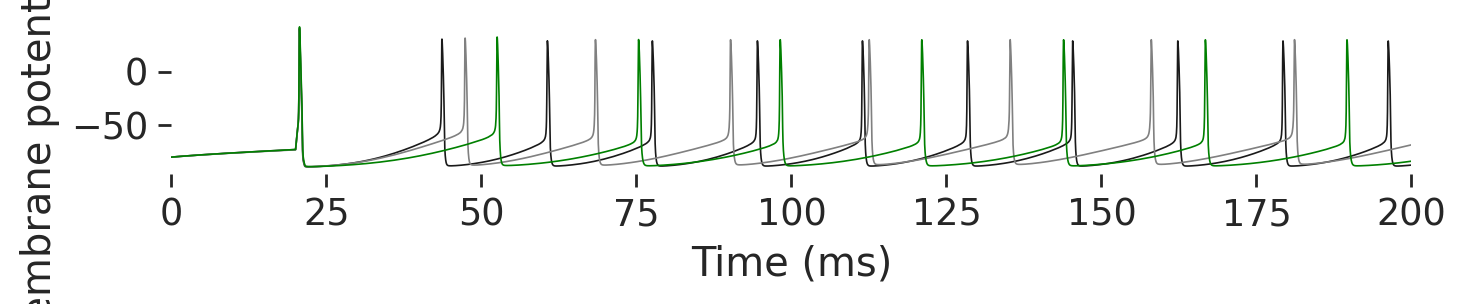

In [14]:
fig, ax = plt.subplots(figsize=(8, 1))
sns.lineplot(
    data=v_df,
    x=TIME_LABEL,
    y=VOLTAGE_LABEL,
    hue="Neuron",
    hue_order=[
        nrn.name[: nrn.name.find("(")].replace("test", "")
        for nrn in [pv_wt, pv_mut_1, pv_mixed]
    ],
    palette=["k", "grey", "green"],
    # style="Neuron",
    # dashes=["", "", (4.8, 1.8)],
    size="loc",
    size_order=["AIS"],
    ax=ax,
    legend=False,
)
# remove borders, labels, and ticks
sns.despine(ax=ax, left=True, bottom=True)
# ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
ax.set_xlim(0, 200)

# Main figure


INFO:vis:saving fig_model
INFO:vis:                 .svg
INFO:vis:saved


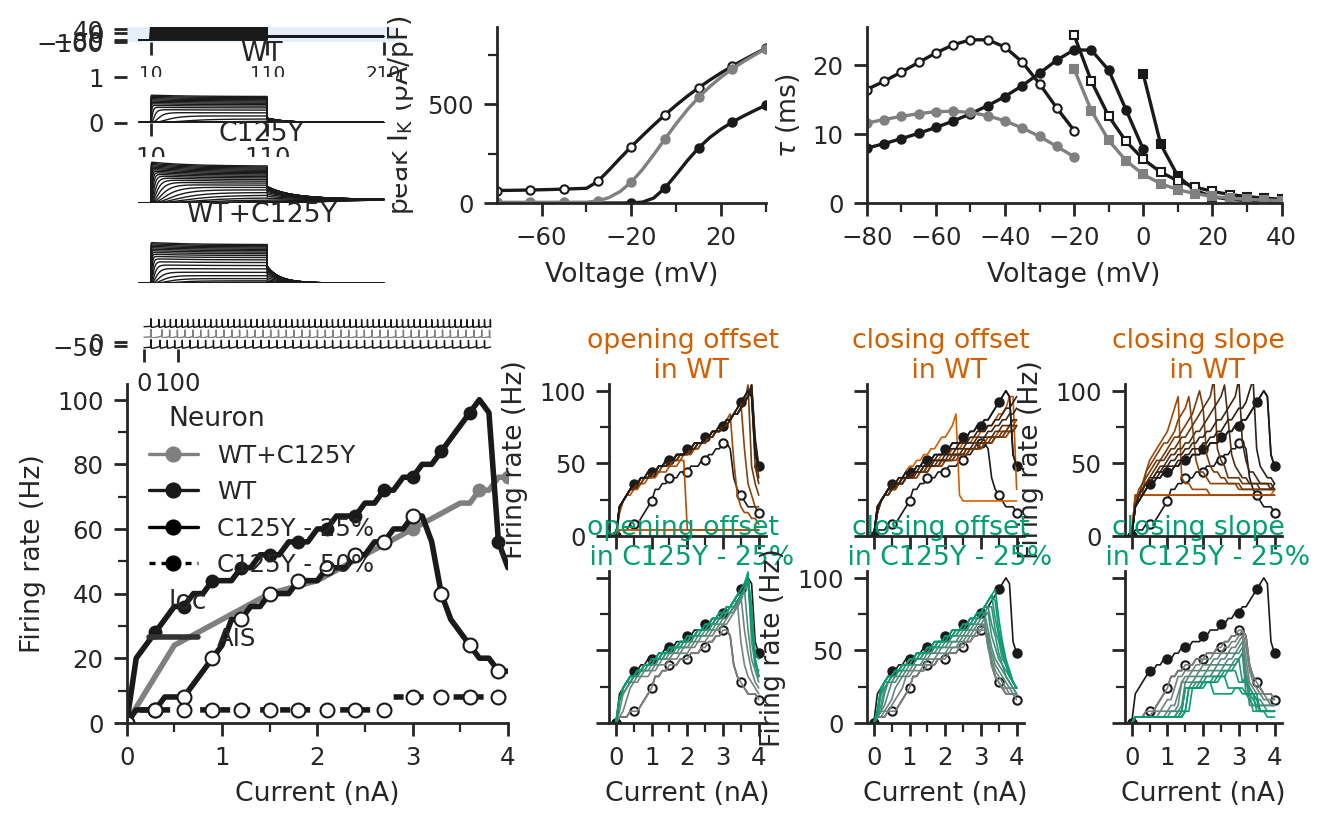

In [60]:
# Figure
##########
from matplotlib.gridspec import GridSpecFromSubplotSpec


set_default_style()
sns.set_context("paper", font_scale=1.0)


fig, axs = plt.subplot_mosaic(
    [
        [".", "v", "i-v peak", "i-v peak", "tau activation", "tau activation"],
        [".", "ik", "i-v peak", "i-v peak", "tau activation", "tau activation"],
        [".", "ik_mut", "i-v peak", "i-v peak", "tau activation", "tau activation"],
        [".", "ik_mixed", ".", ".", ".", "."],
        [
            ".",
            "pv_traces",
            "pv_traces",
            ".",
            ".",
            ".",
        ],
        [".", "pv_frac", "pv_frac", "theta_m_Kv3", "phi_m1_Kv3", "sigma_m1_Kv3"],
        [".", "pv_frac", "pv_frac", "theta_m_Kv3m", "phi_m1_Kv3m", "sigma_m1_Kv3m"],
    ],
    gridspec_kw={
        "height_ratios": [0.1, 0.3, 0.3, 0.3, 0.2, 1, 1],
        "width_ratios": [0.5, 1.2, 0.05] + [0.7] * 3,
        "hspace": 0.5,
        "wspace": 0.7,
        "top": 0.98,
        "right": 0.98,
    },
    dpi=200,
    figsize=(8, 4),
)
# create inset axis
# axs["v"] = axs["ik"].inset_axes([-0.5, 0.9, 1.0, 0.2])
axes_key_names = {
    "theta_m_Kv3": "opening offset",
    "phi_m1_Kv3": "closing offset",
    "theta_m_Kv3m": "opening offset",
    "phi_m1_Kv3m": "closing offset",
    "sigma_m1_Kv3": "closing slope",
    "sigma_m1_Kv3m": "closing slope",
}
axs_params = {key: ax for key, ax in axs.items() if key in axes_key_names}

axs["tau deactivation"] = axs["tau activation"]

gs_traces = GridSpecFromSubplotSpec(
    3, 1, subplot_spec=axs["pv_traces"], hspace=0.1, wspace=0.1
)
axs["pv_traces"].axis(False)
axs["pv_trace"] = fig.add_subplot(gs_traces[0])
axs["pv_trace_mut"] = fig.add_subplot(gs_traces[1])
axs["pv_trace_mixed"] = fig.add_subplot(gs_traces[2])

###############################################################################
# Point neuron data
###############################################################################
activation_result = (
    HashWrapDataFrame(points),
    hashabledict(
        **{k: tuple([HashWrapNDArray(_v) for _v in v]) for k, v in sample_lines.items()}
    ),
    HashWrapNDArray(t_np),
    HashWrapNDArray(plot_vclamp_values),
)
deactivation_result = (
    HashWrapDataFrame(deact_points),
    hashabledict(
        **{k: tuple([HashWrapNDArray(_v) for _v in v]) for k, v in sample_lines.items()}
    ),
    HashWrapNDArray(t_np),
    HashWrapNDArray(plot_deact_vclamp_values),
)

run_iv_figs(
    fig_axs=(fig, hashabledict(axs)),
    activation_result=activation_result,
    deactivation_result=deactivation_result,
    plot_mid_points=False,
    markersize_tau=3,
    markersize_K=3,
    markevery_tau=1,
    markevery_K=3,
)

ymax = np.ceil(max(axs["ik"].get_ylim()[1], axs["ik_mut"].get_ylim()[1], axs["ik_mixed"].get_ylim()[1]))
for ax in [axs["ik"], axs["ik_mut"], axs["ik_mixed"]]:
    ax.set_ylim(0, ymax)

for ax in [axs["v"], axs["ik"], axs["ik_mut"], axs["ik_mixed"]]:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(yticks=[], xticks=[])

xticks = [
    vclamp.dur1,
    vclamp.dur1 + vclamp.dur2,
    vclamp.dur1 + vclamp.dur2 + vclamp.dur3,
]
axs["v"].set_xticks(xticks)
axs["v"].set_xticklabels(np.array(xticks, dtype=int), fontsize="x-small")

axs["ik"].set_yticks([0, ymax])
axs["ik"].set_xticks([10, 110])
axs["v"].set_yticks(sorted(set([vclamp.amp1, vclamp.amp3, -80, 0, 40])))


axs["i-v peak"].set_xticks(
    np.arange(plot_vclamp_values.min() + 20, plot_vclamp_values.max() + 5, 20),
    minor=True,
)
axs["i-v peak"].set_xticks(
    np.arange(plot_vclamp_values.min() + 20, plot_vclamp_values.max() + 5, 40)
)
yticks = axs["i-v peak"].get_yticks()
axs["i-v peak"].set_yticks(
    np.arange(
        yticks[0],
        yticks[-1],
        (yticks[1] - yticks[0]) / 2,
    ),
    minor=True,
)
axs["i-v peak"].set(
    xlabel=VOLTAGE_MV_LABEL,
    xlim=(plot_vclamp_values.min(), 40),
    ylabel="peak $\\rm{I_{K}}$ (pA/pF)",
    title="",
    ylim=(0, points["peak ik"].max()),
)

axs["tau deactivation"].set_xticks(
    np.arange(plot_vclamp_values.min(), plot_vclamp_values.max() + 1, 10), minor=True
)
axs["tau deactivation"].set_xticks(
    np.arange(plot_vclamp_values.min(), plot_vclamp_values.max() + 1, 20)
)
axs["tau deactivation"].set(
    xlabel=VOLTAGE_MV_LABEL,
    xlim=(plot_vclamp_values.min(), 40),
    ylabel="$\\tau$ (ms)",
    title="",
)

###############################################################################
# PV traces
###############################################################################
for nrn, c, ax in zip(
    ["WT", "WT + C125Y", "C125Y - 25%"],
    ["k", "grey", "k"],
    [axs["pv_trace"], axs["pv_trace_mut"], axs["pv_trace_mixed"]],
):
    sns.lineplot(
        data=v_df,
        x=TIME_LABEL,
        y=VOLTAGE_LABEL,
        hue="Neuron",
        hue_order=[nrn],
        palette=[c],
        # palette="Greys_r",
        style="loc",
        style_order=["AIS"],
        ax=ax,
        # alpha=0.5,
        legend=False,
        lw=0.5,
    )
    # remove borders, labels, and ticks
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
    if nrn == "C125Y - 25%":
        # add ticks for scale bars
        ax.set_xticks([0, 100])
        ax.set_yticks([-50, 0])

###############################################################################
# PV compare fractions
###############################################################################
sns.lineplot(
    data=ap_df[ap_df[KVMUT_FRAC_LABEL].isin([0, 0.25, 0.5, 1])],
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="Neuron",
    palette=["grey", "k", "black", "black"],
    style="Neuron",
    dashes=["", "", "", (1.8, 1.8)],
    markers=["o", "o", "o", "o"],
    size="loc",
    size_order=["AIS"],
    sizes=(2, 5),
    ax=axs["pv_frac"],
    markevery=3,
    ms=5,
    mec="k",
    mfc="w",
)
for line in axs["pv_frac"].lines:
    if line.get_color() == "black":
        line.set_color("k")
        line.set_markerfacecolor("w")
    else:
        line.set_markeredgecolor(line.get_color())
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)
        # line.set_markersize(0)

axs["pv_frac"].set_ylim(0, max(100, axs["pv_frac"].get_ylim()[1]))
# set minor y ticks
axs["pv_frac"].set_yticks(np.arange(0, axs["pv_frac"].get_ylim()[1], 10), minor=True)

# set x lim
axs["pv_frac"].set_xlim(0, 4)
# set minor x ticks
axs["pv_frac"].set_xticks(np.arange(0, axs["pv_frac"].get_xlim()[1], 0.5), minor=True)


###############################################################################
# PV compare params
###############################################################################

base_kwargs = dict(
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    style="loc",
    style_order=["AIS"],
    size="Neuron",
)

for i, (key, ax) in enumerate(axs_params.items()):
    col = key.replace(f"_{mech_type}m", "").replace(f"_{mech_type}", "")

    if "Kv3m" in key:
        pal = sns.blend_palette(["grey", "g"], n_colors=len(params[col]))
        ax.set_title(
            f"{axes_key_names[key]} \n in C125Y - 25%", color=pal[-1], va="top"
        )
    else:
        pal = sns.blend_palette(["r", "k"], n_colors=len(params[col]))
        ax.set_title(f"{axes_key_names[key]} \n in WT", color=pal[0], va="top")
        # ax.set_title(axes_key_names[key])

    # plot reference points
    sns.lineplot(
        data=param_df[
            (param_df[col] == param_df[col].min())
            & (param_df["mutation direction"] == "up")
        ],
        **base_kwargs,
        color="k",
        marker="o",
        mfc="w",
        mec="k",
        ms=3,
        markevery=5,
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    sns.lineplot(
        data=param_df[
            (param_df[col] == param_df[col].max())
            & (param_df["mutation direction"] == "down")
        ],
        **base_kwargs,
        color="k",
        marker="o",
        mfc="k",
        mec="k",
        ms=3,
        markevery=5,
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    # plot data
    sns.lineplot(
        data=param_df[param_df["param"] == key],
        ax=ax,
        hue="value",
        palette=pal,
        **base_kwargs,
        # legend=(i == 0),
        legend=False,
    )

    # odd columns
    if i % 2 == 1:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    # all rows except last
    if i < len(axs_params) // 2:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.set_xticks(np.arange(0, ax.get_xlim()[1], 1), minor=False)
    ax.set_xticks(np.arange(0, ax.get_xlim()[1], 0.5), minor=True)


# get max ylim from axes_params dict
# ymax = max(ax.get_ylim()[1] for ax in axes_params.values())
# make all ax in axes_params the same ylim
for ax in axs_params.values():
    ax.set_ylim(0, max(100, axs["pv_frac"].get_ylim()[1]))
    ax.set_yticks(np.arange(0, 100, 25), minor=True)

save_fig("fig_model", formats=("svg",), fig=fig)

### Supplementary figure


INFO:vis:saving fig_model_supp
INFO:vis:                      .svg
INFO:vis:saved


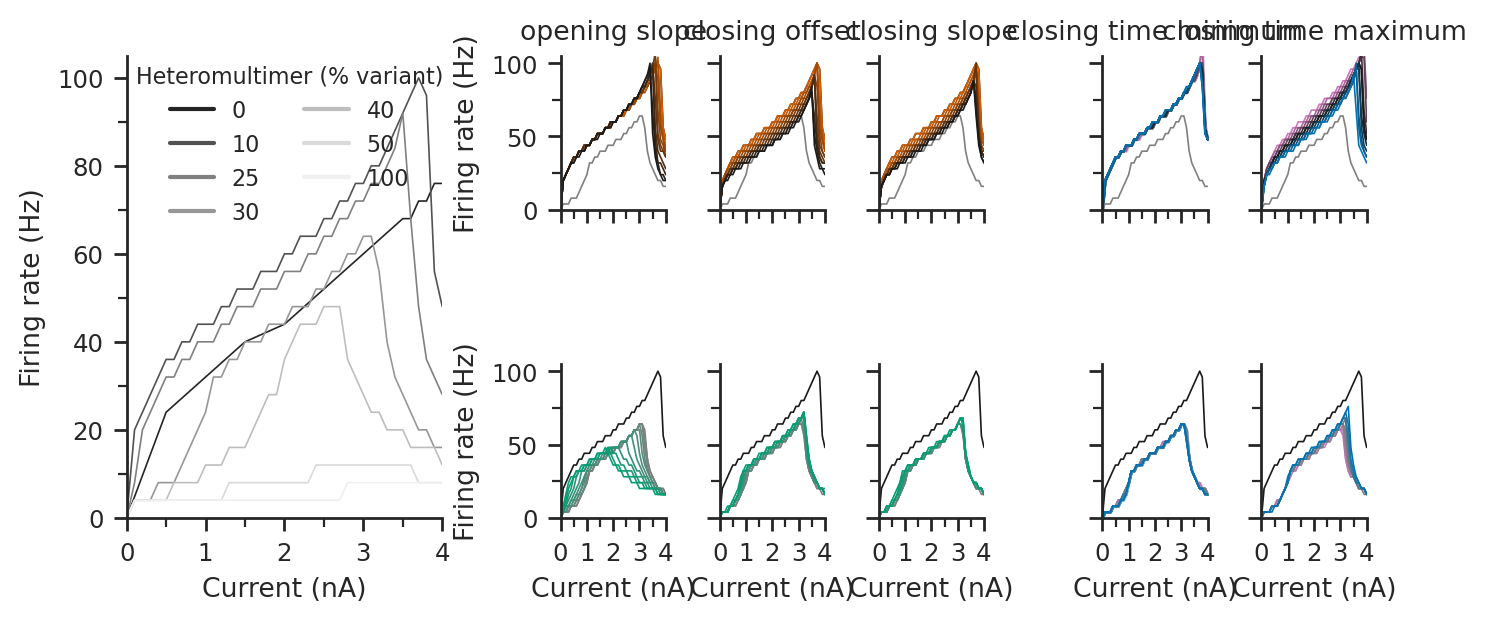

In [ ]:
sns.set_context("paper", font_scale=1.0)

supp_params = ["k_m", "phi_m0", "sigma_m0"]
supp_params_extra = [
    "tau_m0",
    "tau_m1",
]  # these are the same in both channels but varied for robustness

fig, axs = plt.subplot_mosaic(
    [
        ["pv_frac", "."]
        + [f"{s}_{mech_type}" for s in supp_params]
        + ["."]
        + [f"{s}_{mech_type}" for s in supp_params_extra],
        ["pv_frac", "."]
        + [f"{s}_{mech_type}m" for s in supp_params]
        + ["."]
        + [f"{s}_{mech_type}m" for s in supp_params_extra],
    ],
    # sharex=True,
    # sharey=True,
    gridspec_kw={
        "height_ratios": [1, 1],
        "width_ratios": [3, 0.1]
        + [1] * len(supp_params)
        + [0.1]
        + [1] * len(supp_params_extra),
        "hspace": 1.0,
        "wspace": 0.5,
    },
    dpi=200,
    figsize=(8, 3),
)
# create inset axis
# axs["v"] = axs["ik"].inset_axes([-0.5, 0.9, 1.0, 0.2])
axes_key_names = {
    f"k_m_{mech_type}": "opening slope",
    f"phi_m0_{mech_type}": "closing offset",
    f"sigma_m0_{mech_type}": "closing slope",
    f"tau_m0_{mech_type}": "closing time minimum",
    f"tau_m1_{mech_type}": "closing time maximum",
}
items = tuple(axes_key_names.items())
for k, v in items:
    axes_key_names[k + "m"] = v  # add "mutant" to key

axs_params = {key: ax for key, ax in axs.items() if key in axes_key_names}


###############################################################################
# F-I curve
###############################################################################
kvmut_perc = 100 * np.array(sorted(ap_df[KVMUT_FRAC_LABEL].unique()))
pal = sns.color_palette("Greys_r", n_colors=len(kvmut_perc), as_cmap=False)
p25_ind = np.argmin(np.abs(kvmut_perc - 25))
pal[p25_ind] = "grey"

sns.lineplot(
    data=ap_df,
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="Neuron",
    palette=pal,
    # style="Neuron",
    # dashes=['', '', (4.8, 1.8)],
    size="loc",
    size_order=["AIS"],
    ax=axs["pv_frac"],
    legend=False,
)

# seaborn adds box areas (even if not plotted), so we manually specify the lines
# for the legend
lines = [plt.Line2D([0], [0], color=c, linewidth=1.5) for c in pal]

kv_mut_perc_str = [f"{p:.0f}" for p in kvmut_perc]
axs["pv_frac"].legend(
    lines,
    kv_mut_perc_str,
    title="Heteromultimer (% variant)",
    title_fontsize="small",
    fontsize="small",
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    ncol=2,
    borderaxespad=0.0,
)


axs["pv_frac"].set_ylim(0, max(100, axs["pv_frac"].get_ylim()[1]))
# set minor y ticks
axs["pv_frac"].set_yticks(np.arange(0, axs["pv_frac"].get_ylim()[1], 10), minor=True)

# set x lim
axs["pv_frac"].set_xlim(0, 4)
# set minor x ticks
axs["pv_frac"].set_xticks(np.arange(0, axs["pv_frac"].get_xlim()[1], 0.5), minor=True)


###############################################################################
# Params
###############################################################################

down_pal = sns.blend_palette(["r", "k"], n_colors=len(params[supp_params[0]]))
up_pal = sns.blend_palette(["grey", "g"], n_colors=len(params[supp_params[0]]))

base_kwargs = dict(
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    style="loc",
    style_order=["AIS"],
    size="Neuron",
)


for i, (key, ax) in enumerate(axs_params.items()):
    col = key.replace(f"_{mech_type}m", "").replace(f"_{mech_type}", "")
    if f"{mech_type}m" in key:
        pal = (
            sns.blend_palette(["m", "grey", "b"], n_colors=len(params[col]))
            if col in supp_params_extra
            else up_pal
        )
        # ax.set_title(
        #     f"{axes_key_names[key]}", color=pal[-1], va="top"
        # )
    else:
        pal = (
            sns.blend_palette(["m", "k", "b"], n_colors=len(params[col]))
            if col in supp_params_extra
            else down_pal
        )
        # ax.set_title(f"{axes_key_names[key]}", color=pal[0], va="top")
        ax.set_title(axes_key_names[key])

    # plot reference points
    sns.lineplot(
        data=ap_df[ap_df[KVMUT_FRAC_LABEL].isin([0.25])],
        **base_kwargs,
        color="grey",
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    sns.lineplot(
        data=ap_df[ap_df[KVMUT_FRAC_LABEL].isin([0])],
        **base_kwargs,
        color="k",
        ax=ax,
        # linestyle="--",
        legend=False,
    )
    # plot data
    sns.lineplot(
        data=param_df[param_df["param"] == key],
        ax=ax,
        hue="value",
        hue_order=params[col][::-1] if f"{mech_type}m" in key else params[col],
        palette=pal,
        **base_kwargs,
        # legend=(i == 0),
        legend=False,
    )

    # odd columns
    if i > 0 and i != len(axs_params) // 2:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    # all rows except last
    if i < len(axs_params) // 2:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.set_xticks(np.arange(0, ax.get_xlim()[1], 1), minor=False)
    ax.set_xticks(np.arange(0, ax.get_xlim()[1], 0.5), minor=True)
    ax.set_xlim(0, 4)
    ax.set_ylim(0, max(100, axs["pv_frac"].get_ylim()[1]))
    # set minor y ticks
    ax.set_yticks(np.arange(0, axs["pv_frac"].get_ylim()[1], 25), minor=True)


save_fig("fig_model_supp", ("svg",))